<a href="https://colab.research.google.com/github/arssite/arssite/blob/main/Dds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib

In [2]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/driver_drowsiness_detection_modified.zip
!unzip -qo driver_drowsiness_detection_modified.zip

--2024-02-27 15:13:14--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/driver_drowsiness_detection_modified.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.66.104, 52.219.158.203, 52.219.156.183, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.66.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127436131 (122M) [application/x-zip-compressed]
Saving to: ‘driver_drowsiness_detection_modified.zip’

driver_drowsiness_d 100%[===================>] 121.53M  13.3MB/s    in 11s     

2024-02-27 15:13:26 (11.4 MB/s) - ‘driver_drowsiness_detection_modified.zip’ saved [127436131/127436131]



In [3]:
data = np.load('driver_drowsiness_detection/dataset_compressed.npz', allow_pickle=True)
X = data['arr_0']
Y = data['arr_1']

X = list(X)
Y = list(Y)
print(len(X))
print(len(Y))

1452
1452


In [4]:
for i in range(len(X)):
    img = X[i]
    img = cv2.resize(img, (32, 32))
    X[i] = img

print(len(X))
print(X[0].shape)

1452
(32, 32, 3)


In [5]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y.shape)
print(Y[0])
print(set(Y))

(1452,)
0
{0, 1}


In [6]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(1452, 32, 32, 3)
(1452,)


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [8]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1161, 32, 32, 3)
(1161,)
(291, 32, 32, 3)
(291,)
(1161, 32, 32, 3)
(1161, 2)
(291, 32, 32, 3)
(291, 2)


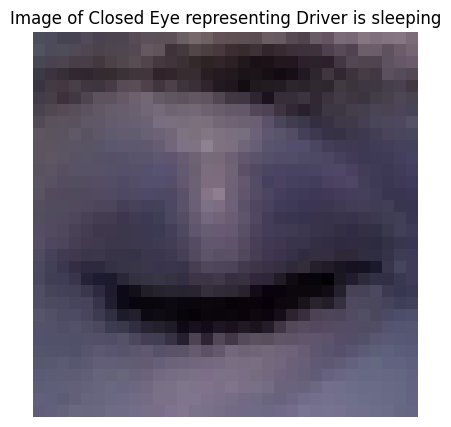

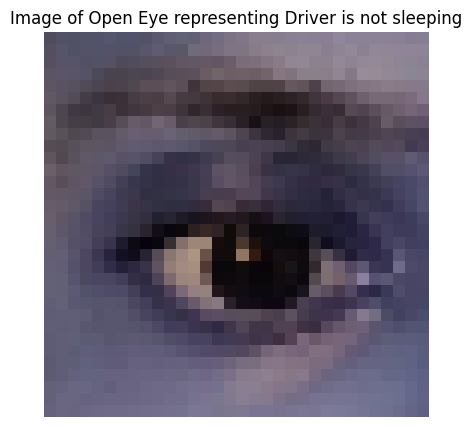

In [9]:
figure1 = plt.figure(figsize=(5, 5))
idx_closed = np.where(Y==0)
img_closed = X[idx_closed[0][0]]
plt.imshow(img_closed)
plt.title('Image of Closed Eye representing Driver is sleeping')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_open = np.where(Y==1)
img_open = X[idx_open[0][0]]
plt.imshow(img_open)
plt.title('Image of Open Eye representing Driver is not sleeping')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Number of training images per category:')

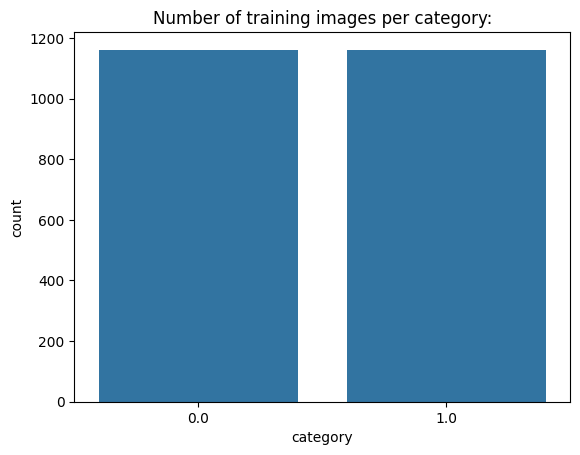

In [12]:
data = {"category": unique_train, "count": count}
sns.barplot(data=data, x="category", y="count").set_title("Number of training images per category:")

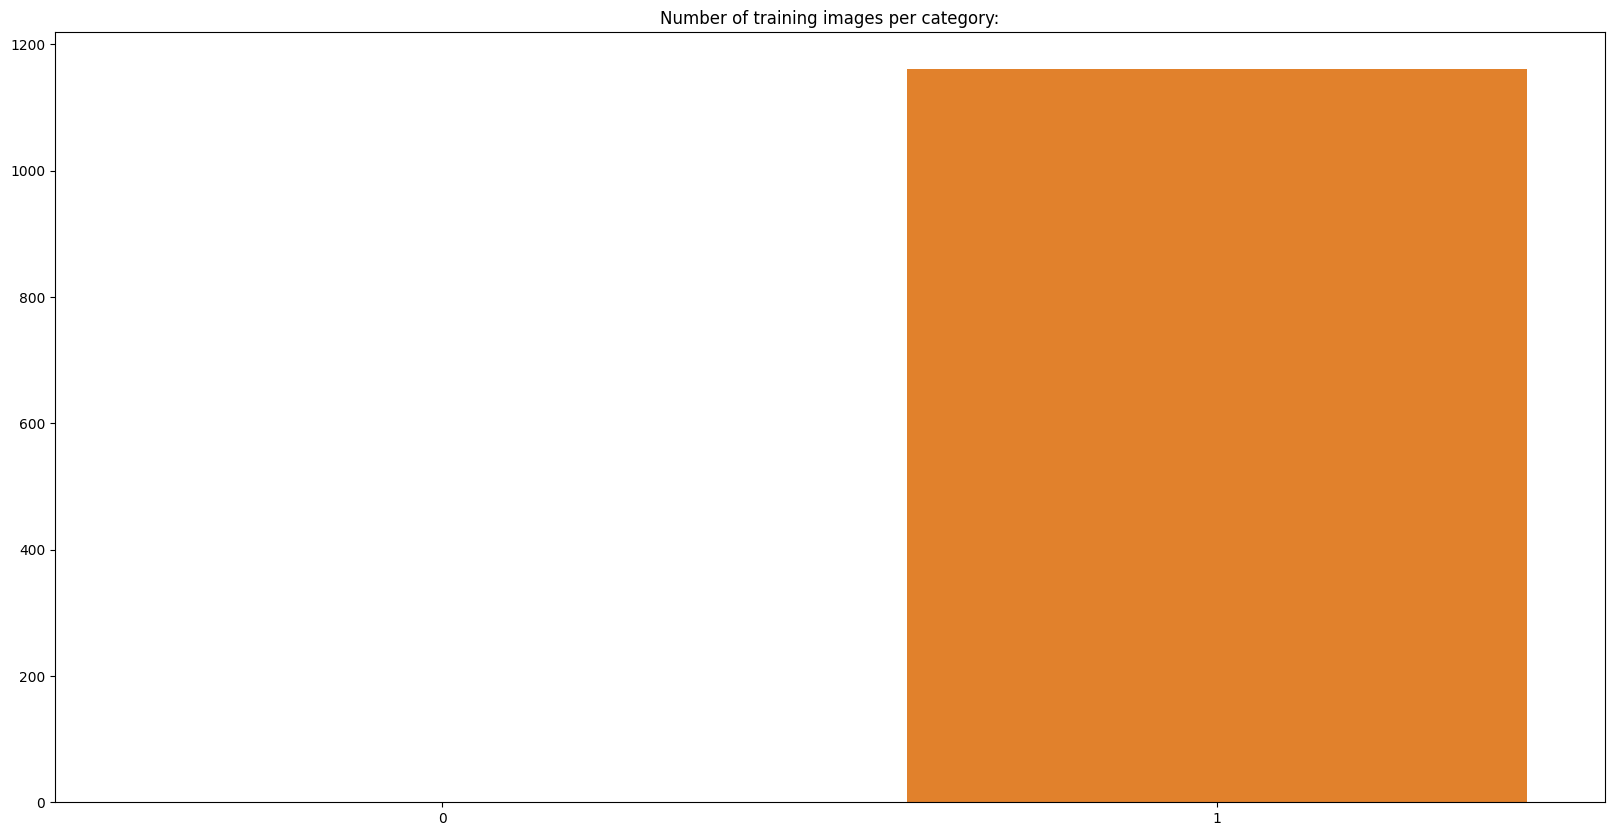

In [15]:
plt.figure(figsize=(20, 10))
sns.barplot((unique_train, count)).set_title("Number of training images per category:")
plt.show()

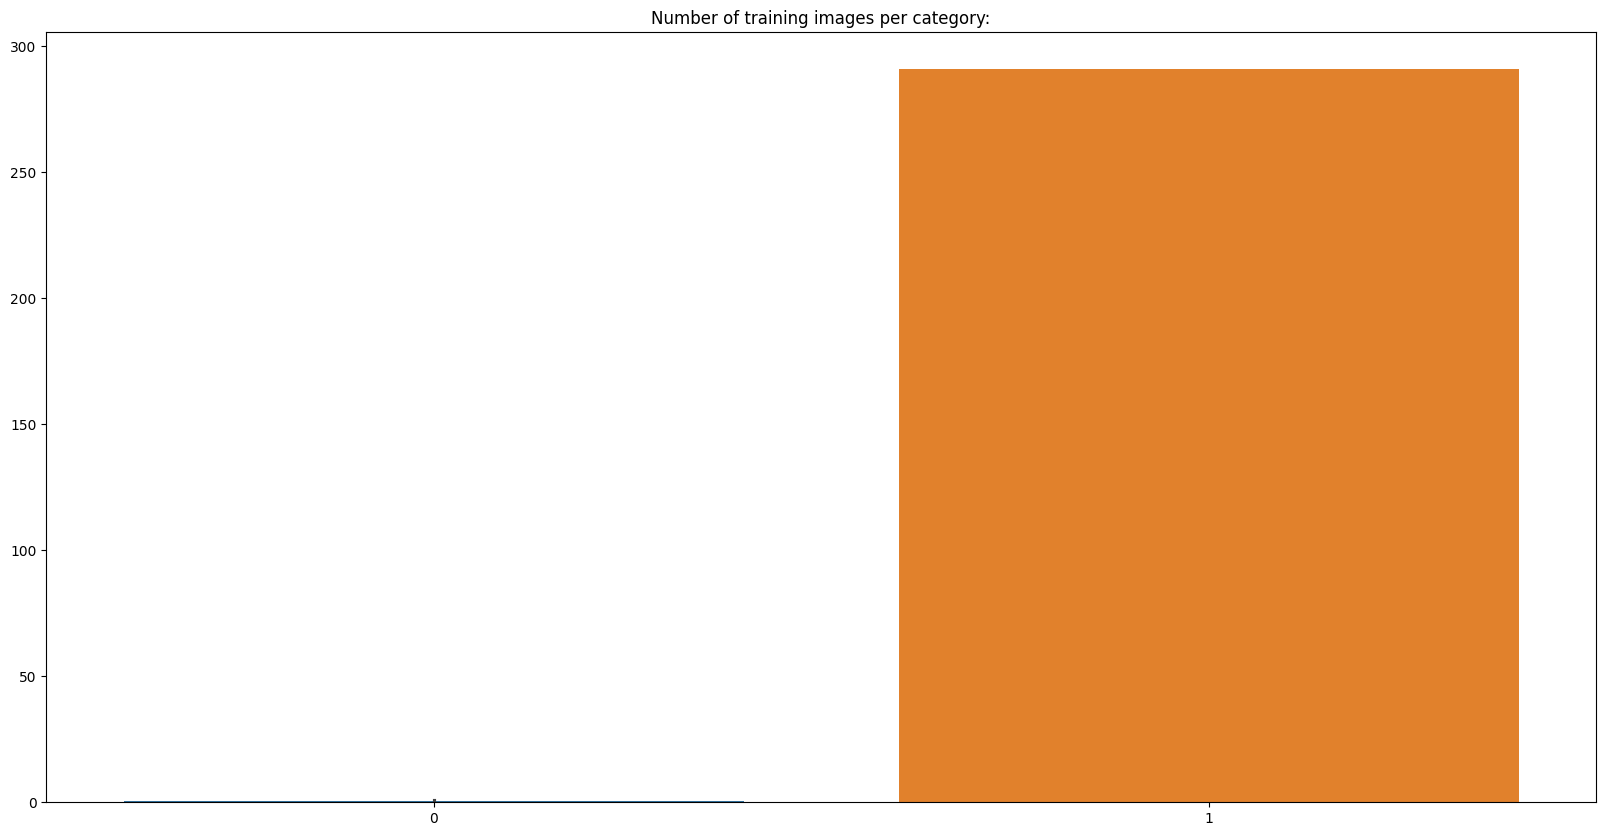

In [13]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(data=[unique_test, count_test]).set_title("Number of training images per category:")
plt.show()

In [16]:
def driver_drowsiness_detection_model(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv1', activation='relu',
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv2', activation='relu',
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu',
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu',
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv5', activation='relu',
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv6', activation='relu',
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv7', activation='relu',
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))


    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))

    optimizer = Adam(0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
model= driver_drowsiness_detection_model(input_shape=(32, 32, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0

In [18]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=200, validation_data=(X_test, Y_test))

Epoch 1/200
10/10 [==============================] - 11s 722ms/step - loss: 1.3730 - accuracy: 0.5047 - val_loss: 0.7006 - val_accuracy: 0.4880
Epoch 2/200
10/10 [==============================] - 7s 648ms/step - loss: 1.1600 - accuracy: 0.5512 - val_loss: 0.6818 - val_accuracy: 0.4914
Epoch 3/200
10/10 [==============================] - 7s 742ms/step - loss: 1.0293 - accuracy: 0.5728 - val_loss: 0.6580 - val_accuracy: 0.5395
Epoch 4/200
10/10 [==============================] - 8s 812ms/step - loss: 0.9674 - accuracy: 0.5788 - val_loss: 0.6391 - val_accuracy: 0.5979
Epoch 5/200
10/10 [==============================] - 7s 682ms/step - loss: 0.9364 - accuracy: 0.6029 - val_loss: 0.6318 - val_accuracy: 0.6873
Epoch 6/200
10/10 [==============================] - 8s 694ms/step - loss: 0.8969 - accuracy: 0.5883 - val_loss: 0.6282 - val_accuracy: 0.7148
Epoch 7/200
10/10 [==============================] - 8s 760ms/step - loss: 0.8179 - accuracy: 0.6021 - val_loss: 0.6193 - val_accuracy: 0.756

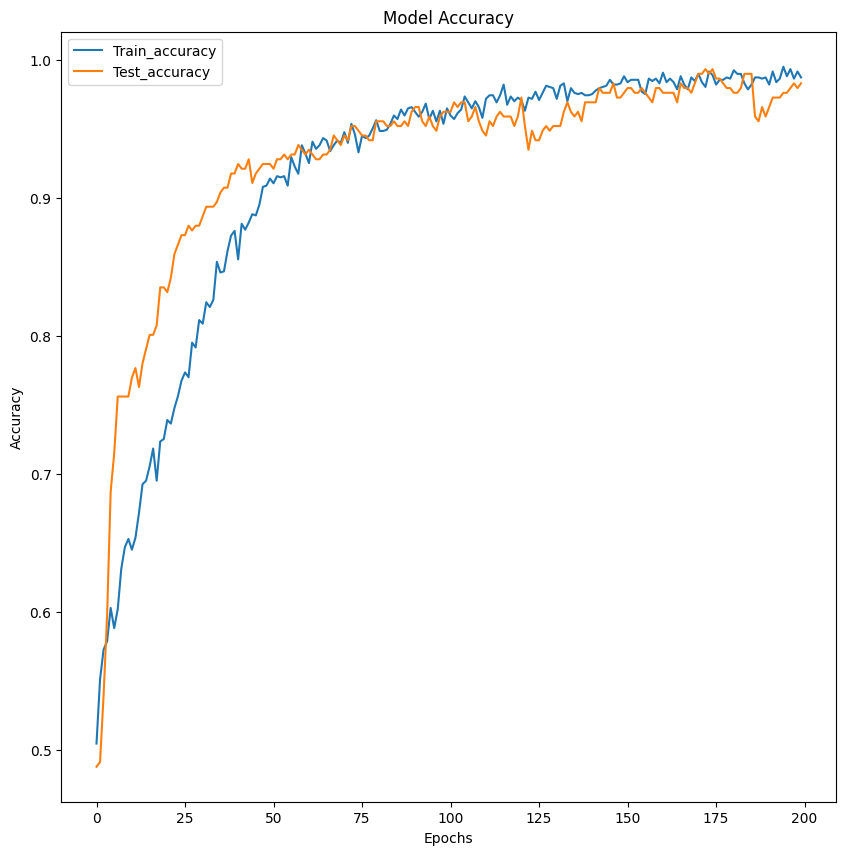

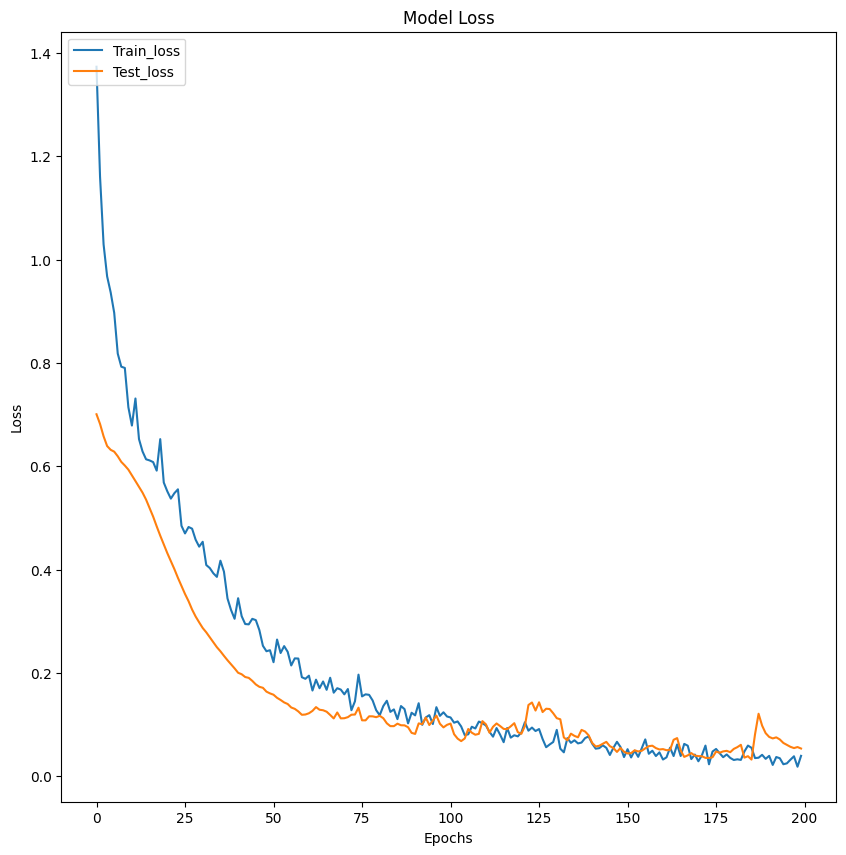

In [19]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [20]:
pred = model.evaluate(X_test, Y_test)
print(f'Test Set Accuracy: {pred[1]}')
print(f'Test Set Loss: {pred[0]}')

10/10 [==============================] - 0s 37ms/step - loss: 0.0539 - accuracy: 0.9828
Test Set Accuracy: 0.9828178882598877
Test Set Loss: 0.053876735270023346


In [22]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_pred = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_pred, ypred))

10/10 [==============================] - 1s 65ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       149
           1       0.97      0.99      0.98       142

    accuracy                           0.98       291
   macro avg       0.98      0.98      0.98       291
weighted avg       0.98      0.98      0.98       291



<Axes: >

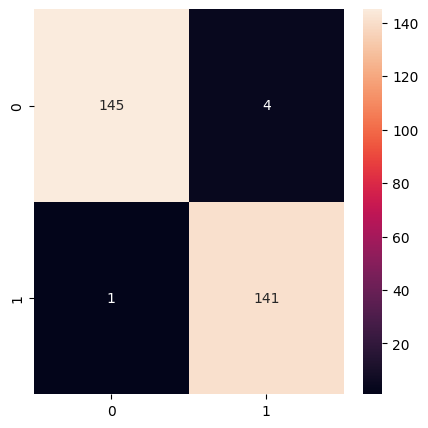

In [23]:
matrix = confusion_matrix(Y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

In [24]:
model.save('Driver_Drowsiness_Detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
labels = ['Closed', 'Open']
img_closed1 = cv2.imread('driver_drowsiness_detection/closed_eye.jpg')
img_closed2 = cv2.imread('driver_drowsiness_detection/closed_eye2.jpg')
img_open1 = cv2.imread('driver_drowsiness_detection/open_eye.jpg')
img_open2 = cv2.imread('driver_drowsiness_detection/open_eye2.jpg')

img_closed1 = cv2.resize(img_closed1, (32, 32))
img_closed2 = cv2.resize(img_closed2, (32, 32))
img_open1 = cv2.resize(img_open1, (32, 32))
img_open2 = cv2.resize(img_open2, (32, 32))

img_closed1 = np.array(img_closed1)
img_closed2 = np.array(img_closed2)
img_open1 = np.array(img_open1)
img_open2 = np.array(img_open2)

img_closed1 = np.expand_dims(img_closed1, axis=0)
img_closed2 = np.expand_dims(img_closed2, axis=0)
img_open1 = np.expand_dims(img_open1, axis=0)
img_open2 = np.expand_dims(img_open2, axis=0)

In [26]:
open2 = np.expand_dims(img_open2, axis=0)
ypred_closed1 = model.predict(img_closed1)
ypred_closed2 = model.predict(img_closed2)
ypred_open1 = model.predict(img_open1)
ypred_open2 = model.predict(img_open2)

1/1 [==============================] - 0s 39ms/step


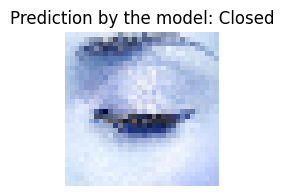

In [27]:
figure = plt.figure(figsize=(2, 2))
img_closed1 = np.squeeze(img_closed1, axis=0)
plt.imshow(img_closed1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed1[0], axis=0)]}')
plt.show()

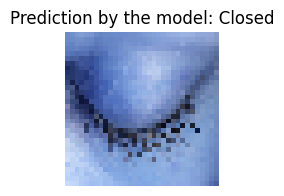

In [28]:
figure = plt.figure(figsize=(2, 2))
img_closed2 = np.squeeze(img_closed2, axis=0)
plt.imshow(img_closed2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed2[0], axis=0)]}')
plt.show()

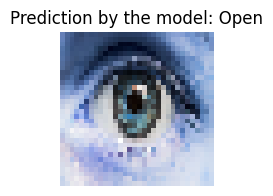

In [29]:
figure = plt.figure(figsize=(2, 2))
img_open1 = np.squeeze(img_open1, axis=0)
plt.imshow(img_open1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open1[0], axis=0)]}')
plt.show()

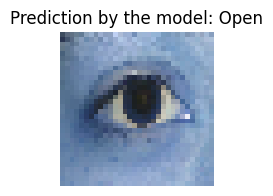

In [30]:
figure = plt.figure(figsize=(2, 2))
img_open2 = np.squeeze(img_open2, axis=0)
plt.imshow(img_open2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open2[0], axis=0)]}')
plt.show()

In [34]:
def full_face_detection_pipeline(input_image_path):
    face_cascade = cv2.CascadeClassifier('/content/driver_drowsiness_detection/haarcascade_eye.xml')
    eye_cascade = cv2.CascadeClassifier('/content/driver_drowsiness_detection/haarcascade_eye.xml')
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('/content/driver_drowsiness_detection/shape_predictor_68_face_landmarks.dat')
    fa = FaceAligner(predictor, desiredFaceWidth=256)
    test_image = cv2.imread(input_image_path)
    test_image = imutils.resize(test_image, width=800)
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    rects = detector(test_image_gray, 2)
    for rect in rects:
        (x, y, w, h) = rect_to_bb(rect)
        faceOrig = imutils.resize(test_image[y:y+h, x:x+w], width=256)
        faceAligned = fa.align(test_image, test_image_gray, rect)
        faceAligned_gray = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2GRAY)
        plt.imshow(faceAligned_gray)
        plt.axis('off')
        plt.title('Aligned Face')
        plt.show()
        eyes = eye_cascade.detectMultiScale(faceAligned_gray, 1.1, 4)
        predictions = []
        for (ex, ey, ew, eh) in eyes:
            eye = faceAligned[ey:ey+eh, ex:ex+ew]
#             cv2.rectangle(test_image, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 0, 255), 8)
            eye = cv2.resize(eye, (32, 32))
            eye = np.array(eye)
            eye = np.expand_dims(eye, axis=0)
            ypred = model.predict(eye)
            ypred = np.argmax(ypred[0], axis=0)
            predictions.append(ypred)
        if all(i==0 for i in predictions):
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 0, 255), 8)
            cv2.putText(test_image, 'Sleeping', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        else:
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 8)
            cv2.putText(test_image, 'Not Sleeping', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    output_path = '/content/driver_drowsiness_detection/test_image_prediction.jpg'
    cv2.imwrite(output_path, test_image)
    return output_path

In [53]:
!pip install imutils

In [54]:
import imutils
import cv2
import matplotlib.pyplot as plt

In [56]:
full_face_detection_pipeline('/content/driver_drowsiness_detection/active_person.jpg')

TypeError: Can't parse 'center'. Sequence item with index 0 has a wrong type

In [52]:
# Load the image
image = cv2.imread('/content/driver_drowsiness_detection/active_person.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
rects = face_cascade.detectMultiScale(gray, 1.3, 5)

# Align the first detected face
for (x, y, w, h) in rects:
    faceAligned = fa.align(image, gray, (x, y, w, h), center=eyesCenter)
    break

# Display the aligned face
plt.imshow(faceAligned)
plt.axis('off')
plt.show()

NameError: name 'face_cascade' is not defined

In [51]:
figure = plt.figure(figsize=(5, 5))
predicted_image = cv2.imread(full_face_detection_pipeline('/content/driver_drowsiness_detection/active_person.jpg',full_face_detection_pipeline('/content/driver_drowsiness_detection/active_person.jpg', center=eyesCenter)))
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
plt.imshow(predicted_image)
plt.axis('off')
plt.show()

NameError: name 'eyesCenter' is not defined

<Figure size 500x500 with 0 Axes>

In [36]:
import cv2
import matplotlib.pyplot as plt
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils

In [40]:
# Assuming 'eyesCenter' is a tuple or list containing (x, y) coordinates
cv2.getRotationMatrix2D(eyesCenter, angle, scale)

NameError: name 'eyesCenter' is not defined

In [41]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib
import tensorflow as tf

In [42]:
## Use an offline video
#vid = cv2.VideoCapture('red-ball.webm')
vid = cv2.VideoCapture('Driver_Drowsiness.mp4')

In [44]:
## Use real-time video capturing
#cameraID = 0 # 0 => Laptop's webcam ID
vid = cv2.VideoCapture(0)
model = tf.keras.models.load_model("/content/Driver_Drowsiness_Detection.h5")


In [46]:
eye_cascade = cv2.CascadeClassifier('driver_drowsiness_detection/haarcascade_eye.xml')
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('driver_drowsiness_detection/shape_predictor_68_face_landmarks.dat')
fa = FaceAligner(predictor, desiredFaceWidth=256)

In [47]:
def full_face_detection_pipeline(input_image_path):
    test_image = cv2.imread(input_image_path)
    test_image = imutils.resize(test_image, width=800)
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    rects = detector(test_image_gray, 2)
    for rect in rects:
        (x, y, w, h) = rect_to_bb(rect)
        faceOrig = imutils.resize(test_image[y:y+h, x:x+w], width=256)
        faceAligned = fa.align(test_image, test_image_gray, rect)
        faceAligned_gray = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2GRAY)
        plt.imshow(faceAligned_gray)
        plt.axis('off')
        plt.title('Aligned Face')
        plt.show()
        eyes = eye_cascade.detectMultiScale(test_image, 1.1, 4)
        predictions = []
        for (ex, ey, ew, eh) in eyes:
            eye = faceAligned[ey:ey+eh, ex:ex+ew]
#             cv2.rectangle(test_image, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 0, 255), 8)
            eye = cv2.resize(eye, (32, 32))
            eye = np.array(eye)
            eye = np.expand_dims(eye, axis=0)
            ypred = model.predict(eye)
            ypred = np.argmax(ypred[0], axis=0)
            predictions.append(ypred)
        if all(i==0 for i in predictions):
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 0, 255), 8)
            cv2.putText(test_image, 'Sleeping', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        else:
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 8)
            cv2.putText(test_image, 'Not Sleeping', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    output_path = '/content/driver_drowsiness_detection/test_image_prediction.jpg'
    #cv2.imwrite(output_path, test_image)
    return output_path

In [45]:
###############################################################
##                    Video Input Capture                    ##
###############################################################




# cascPathface = os.path.dirname(
#     cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
# cascPatheyes = os.path.dirname(
#     cv2.__file__) + "/data/haarcascade_eye_tree_eyeglasses.xml"

# face_cascade = cv2.CascadeClassifier('driver_drowsiness_detection/haarcascade_frontalface_default.xml')

# faceCascade = cv2.CascadeClassifier(cascPathface)
# eyeCascade = cv2.CascadeClassifier(cascPatheyes)

while True:
    ## Capture one frame from the video capture
    _, image = vid.read()
    figure = plt.figure(figsize=(5, 5))

    predicted_image = cv2.imread(full_face_detection_pipeline(image))
    predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
    plt.imshow(predicted_image)
    plt.axis('off')
    plt.show()
    ## Break key
    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break
vid.release()
cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute 'shape'

<Figure size 500x500 with 0 Axes>